## **ΕΠ08 Αναγνώριση Προτύπων - Μηχανική Μάθηση**


## **Ερώτημα 1: Feedforward Neural Network**

Τα νευρωνικά δίκτυα είναι ένα από τα βασικά εργαλεία της μηχανικής μάθησης. Πρόκειται για μοντέλα εμπνευσμένα από τον ανθρώπινο εγκέφαλο. Αποτελούνται από νευρώνες που είναι οργανωμένοι σε επίπεδα. Κάθε νευρώνας λαμβάνει δεδομένα, τα επεξεργάζεται και τα μεταδίδει στον επόμενο. Τα νευρωνικά δίκτυα χρησιμοποιούνται σε πολλές εφαρμογές όπως η αναγνώριση εικόνας, η επεξεργασία φυσικής γλώσσας, και η πρόβλεψη δεδομένων. \\
Στην συγκεκριμένη εργασία θα μελετήσουμε τη χρήση τους στην πρόβλεψη μουσικού είδους από σήματα μουσικής. Για την διεκπεραίωση της, θα ακολουθήσουμε τα βήματα που δίνονται στην εκφώνηση. \\
Ξεκινάμε με τη δήλωση των βιβλιοθηκών που θα χρησιμοποιήσουμε και τη σύνδεση με το Google Drive:

In [ ]:
import numpy as np
import os
import random
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### Βήμα 1: Φόρτωση δεδομένων (mfccs)

Στην εκφώνηση αναφέρονται ως είδη μουσικής που θα αναλύσουμε rock, blues, classical, pop. Στο σύνολο δεδομένων που μας δίδεται, υπάρχουν οι τίτλοι blues, classical, hiphop, rock_metal_hardrock και επομένως θα υλοποιήσουμε τον κώδικα με βάση αυτούς.

In [ ]:
train_mfccs_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/train/mfccs/X.npy')).to(torch.float)
train_mfccs_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/train/mfccs/labels.npy')
val_mfccs_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/val/mfccs/X.npy')).to(torch.float)
val_mfccs_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/val/mfccs/labels.npy')
test_mfccs_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/test/mfccs/X.npy')).to(torch.float)
test_mfccs_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/test/mfccs/labels.npy')

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.targets[index]
        return sample, label

labels_map = {
    "blues" : 0,
    "rock_metal_hardrock" : 1,
    "classical": 2,
    "hiphop": 3
}


def mapping_function(labels_map,x):
    return labels_map[x]



train_mfccs_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in train_mfccs_labels]))
val_mfccs_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in val_mfccs_labels]))
test_mfccs_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in test_mfccs_labels]))


train_mfccs_dataset = CustomDataset(train_mfccs_X,train_mfccs_labels_code)
val_mfccs_dataset = CustomDataset(val_mfccs_X,val_mfccs_labels_code)
test_mfccs_dataset = CustomDataset(test_mfccs_X,test_mfccs_labels_code)


train_dataloader = DataLoader(train_mfccs_dataset, batch_size=16, shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_mfccs_dataset, batch_size=16, shuffle=True,num_workers=2,pin_memory=True)
test_dataloader = DataLoader(test_mfccs_dataset, batch_size=16, shuffle=True,num_workers=2,pin_memory=True)

print('Training set has {} instances'.format(len(train_dataloader)))  ## 3200/16=200
print('Validation set has {} instances'.format(len(val_dataloader)))  ## 800/16=50
print('Testing set has {} instances'.format(len(test_dataloader)))  ## 1376/16=86


Training set has 200 instances
Validation set has 50 instances
Testing set has 86 instances


### Βήμα 2: Ορισμός Νευρωνικού Δικτύου



In [ ]:
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        #input 26 --> 128 --> 32 --> 4 output
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26, 128),  ## 26-->128 input layer
            nn.ReLU(),
            nn.Linear(128, 32),  ## 128-->32 hidden layer
            nn.ReLU(),
            nn.Linear(32, 4),    ## 32-->4 output layer
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [ ]:
def train_loop(train_dataloader, my_nn, loss_function, optimizer,device):
  size = len(train_dataloader.dataset)
  for batch,(X, y) in enumerate(train_dataloader):

    X = X.to(device)
    y = y.to(device)

    #prediction & loss
    y_hat = my_nn(X)
    loss = loss_function(y_hat,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


### Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [ ]:
def test_loop(test_dataloader, my_nn, loss_function,device):
  size = len(test_dataloader.dataset)
  y_true = []
  y_pred = []
  test_loss = 0
  for batch, (X, y) in enumerate(test_dataloader):

    X = X.to(device)
    y = y.to(device)

    y_hat = my_nn(X)
    loss = loss_function(y_hat,y)

    y_true += [y]
    y_pred += [y_hat.argmax(dim=1)]

    test_loss += loss.item()


  y_true_np = np.concatenate([item.detach().numpy() for item in y_true])
  y_pred_np = np.concatenate([item.detach().numpy() for item in y_pred])

  avg_loss = loss/size
  #f1 macro-averaged
  f1_macro_averaged = f1_score(y_true_np, y_pred_np, average='macro')
  #accuracy
  accuracy = accuracy_score(y_true_np, y_pred_np)
  #confusion matrix
  confusionMatrix = confusion_matrix(y_true_np, y_pred_np)

  return f1_macro_averaged,avg_loss,accuracy,confusionMatrix

### Βήμα 5: Εκπαίδευση δικτύου

In [ ]:
device = 'cpu'
my_nn = FeedforwardNeuralNetwork().to(device)
learning_rate = 2e-3
epochs_number = 30
optimizer = torch.optim.SGD(my_nn.parameters(),lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


for t in range(epochs_number):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, my_nn, loss_function, optimizer,device)
    f1_macro_averaged,avg_loss,accuracy,confusionMatrix = test_loop(test_dataloader, my_nn, loss_function,device)

    print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {100 * avg_loss:>8f} %, macro F1 score: {f1_macro_averaged}%,\n confusion matrix: {confusionMatrix}\n")


print("End")

Epoch 1
-------------------------------
loss: 1.259855  [    0/ 3200]
loss: 1.291660  [  160/ 3200]
loss: 1.263813  [  320/ 3200]
loss: 1.354172  [  480/ 3200]
loss: 1.384570  [  640/ 3200]
loss: 1.385489  [  800/ 3200]
loss: 1.361672  [  960/ 3200]
loss: 1.388346  [ 1120/ 3200]
loss: 1.388235  [ 1280/ 3200]
loss: 1.399827  [ 1440/ 3200]
loss: 1.394066  [ 1600/ 3200]
loss: 1.372557  [ 1760/ 3200]
loss: 1.401648  [ 1920/ 3200]
loss: 1.390022  [ 2080/ 3200]
loss: 1.398796  [ 2240/ 3200]
loss: 1.381918  [ 2400/ 3200]
loss: 1.380145  [ 2560/ 3200]
loss: 1.371470  [ 2720/ 3200]
loss: 1.389938  [ 2880/ 3200]
loss: 1.390084  [ 3040/ 3200]
Test Error: 
 Accuracy: 25.9%, Avg loss: 0.102046 %, macro F1 score: 0.10408073367995378%,
 confusion matrix: [[  0   0   0 324]
 [  0   1   0 398]
 [  0   0   0 297]
 [  0   0   0 356]]

Epoch 2
-------------------------------
loss: 1.380548  [    0/ 3200]
loss: 1.394991  [  160/ 3200]
loss: 1.383604  [  320/ 3200]
loss: 1.368413  [  480/ 3200]
loss: 1.4075

### Βήμα 6: Εκπαίδευση δικτύου με GPU

In [ ]:
if torch.cuda.is_available():
  print('Gpu available!')
  device = 'cuda'
else:
  print('No available gpu...')
  device = 'cpu'

my_nn = FeedforwardNeuralNetwork().to(device)
learning_rate = 2e-3
epochs_number = 30
optimizer = torch.optim.SGD(my_nn.parameters(),lr = learning_rate)
loss_function = nn.CrossEntropyLoss()


for t in range(epochs_number):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, my_nn, loss_function, optimizer,device)
    f1_macro_averaged,avg_loss,accuracy,confusionMatrix = test_loop(test_dataloader, my_nn, loss_function,device)

    print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {100 * avg_loss:>8f} %, macro F1 score: {f1_macro_averaged}%,\n confusion matrix: {confusionMatrix}\n")


print("End")

No available gpu...
Epoch 1
-------------------------------
loss: 1.548200  [    0/ 3200]
loss: 1.274898  [  160/ 3200]
loss: 1.428164  [  320/ 3200]
loss: 1.395170  [  480/ 3200]
loss: 1.359846  [  640/ 3200]
loss: 1.337604  [  800/ 3200]
loss: 1.385125  [  960/ 3200]
loss: 1.386303  [ 1120/ 3200]
loss: 1.388488  [ 1280/ 3200]
loss: 1.388410  [ 1440/ 3200]
loss: 1.391751  [ 1600/ 3200]
loss: 1.379709  [ 1760/ 3200]
loss: 1.369186  [ 1920/ 3200]
loss: 1.378685  [ 2080/ 3200]
loss: 1.383228  [ 2240/ 3200]
loss: 1.383664  [ 2400/ 3200]
loss: 1.413329  [ 2560/ 3200]
loss: 1.380591  [ 2720/ 3200]
loss: 1.403100  [ 2880/ 3200]
loss: 1.374100  [ 3040/ 3200]
Test Error: 
 Accuracy: 28.4%, Avg loss: 0.100825 %, macro F1 score: 0.1567917505625693%,
 confusion matrix: [[  3  14   0 307]
 [  4  30   0 365]
 [ 59  53   6 179]
 [  3   1   0 352]]

Epoch 2
-------------------------------
loss: 1.381452  [    0/ 3200]
loss: 1.370800  [  160/ 3200]
loss: 1.373484  [  320/ 3200]
loss: 1.381170  [  480/

### Βήμα 7: Επιλογή μοντέλου

In [ ]:
device = 'cpu'
my_nn = FeedforwardNeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss() #loss function

learning_rate = 2e-3
epochs_number = 30
tmp=0
optimizer = torch.optim.SGD(my_nn.parameters(), lr = learning_rate) # stochastic gradient descent

best_f1 = float('-inf')
best_model_state = None

print(f"using cpu\n")
for t in range(epochs_number):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, my_nn, loss_fn, optimizer,device)
    f1_macro_averaged,avg_loss,accuracy,confusionMatrix = test_loop(test_dataloader, my_nn, loss_fn, device)

    if best_f1 < f1_macro_averaged:
      best_f1 = f1_macro_averaged
      best_model_state = my_nn.state_dict()

best_model = FeedforwardNeuralNetwork()
best_model.load_state_dict(best_model_state)

for t in range(epochs_number):
    print(f"Epoch {t+1}\n-------------------------------")
    f1_macro_averaged,avg_loss,accuracy,confusionMatrix = test_loop(val_dataloader, my_nn, loss_fn, device)
    print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {100 * avg_loss:>8f} %, macro F1 score: {f1_macro_averaged}%,\n confusion matrix: {confusionMatrix}\n")

print("End")

using cpu

Epoch 1
-------------------------------
loss: 1.293246  [    0/ 3200]
loss: 1.482682  [  160/ 3200]
loss: 1.386230  [  320/ 3200]
loss: 1.413867  [  480/ 3200]
loss: 1.413567  [  640/ 3200]
loss: 1.372358  [  800/ 3200]
loss: 1.379910  [  960/ 3200]
loss: 1.425685  [ 1120/ 3200]
loss: 1.395513  [ 1280/ 3200]
loss: 1.383633  [ 1440/ 3200]
loss: 1.366279  [ 1600/ 3200]
loss: 1.374382  [ 1760/ 3200]
loss: 1.349976  [ 1920/ 3200]
loss: 1.400912  [ 2080/ 3200]
loss: 1.362132  [ 2240/ 3200]
loss: 1.376624  [ 2400/ 3200]
loss: 1.383679  [ 2560/ 3200]
loss: 1.374609  [ 2720/ 3200]
loss: 1.373718  [ 2880/ 3200]
loss: 1.386028  [ 3040/ 3200]
Epoch 2
-------------------------------
loss: 1.371740  [    0/ 3200]
loss: 1.381672  [  160/ 3200]
loss: 1.352445  [  320/ 3200]
loss: 1.363302  [  480/ 3200]
loss: 1.376563  [  640/ 3200]
loss: 1.356817  [  800/ 3200]
loss: 1.376375  [  960/ 3200]
loss: 1.360871  [ 1120/ 3200]
loss: 1.365812  [ 1280/ 3200]
loss: 1.352495  [ 1440/ 3200]
loss: 1.3

Ως ένα σχόλιο για το συγκεκριμένο ερώτημα και τα αποτελέσματά του, παρατηρούμε ότι η μέση απώλεια του μοντέλου παρουσιάζει σημαντικές διαφοροποιήσες στην τιμή του, παρότι η ακρίβεια (accuracy) παραμένει σταθερή.

## **Ερώτημα 2: Convolutional Neural Network**

Σε αυτή την ανάλυση, θα χρησιμοποιήσουμε mel-spectograms ως εισόδους για συνελικτικά νευρωνικά δίκτυα (Convolutional Neural Networks – CNNs) με στόχο να ταξινομήσουμε αυτά τα δεδομένα σε διαφορετικά μουσικά είδη.

## Βήμα 1: Φόρτωση δεδομένων (spectrograms)

In [ ]:
train_melgrams_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/train/melgrams/X.npy')).to(torch.float)
train_melgrams_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/train/melgrams/labels.npy')
val_melgrams_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/val/melgrams/X.npy')).to(torch.float)
val_melgrams_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/val/melgrams/labels.npy')
test_melgrams_X = torch.from_numpy(np.load('/content/drive/MyDrive/ML3/music_genre_data_di/test/melgrams/X.npy')).to(torch.float)
test_melgrams_labels = np.load('/content/drive/MyDrive/ML3/music_genre_data_di/test/melgrams/labels.npy')

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.targets[index]
        return sample, label

labels_map = {
    "blues" : 0,
    "rock_metal_hardrock" : 1,
    "classical": 2,
    "hiphop": 3
}


def mapping_function(labels_map,x):
    return labels_map[x]



train_melgrams_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in train_melgrams_labels]))
val_melgrams_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in val_melgrams_labels]))
test_melgrams_labels_code = torch.from_numpy(np.array([mapping_function(labels_map,x) for x in test_melgrams_labels]))


train_melgrams_dataset = CustomDataset(train_melgrams_X,train_melgrams_labels_code)
val_melgrams_dataset = CustomDataset(val_melgrams_X,val_melgrams_labels_code)
test_melgrams_dataset = CustomDataset(test_melgrams_X,test_melgrams_labels_code)


train_dataloader = DataLoader(train_melgrams_dataset, batch_size=16, shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_melgrams_dataset, batch_size=16, shuffle=True,num_workers=2,pin_memory=True)
test_dataloader = DataLoader(test_melgrams_dataset, batch_size=16, shuffle=True,num_workers=2,pin_memory=True)

print('Training set has {} instances'.format(len(train_dataloader)))  ## 3200/16=200
print('Validation set has {} instances'.format(len(val_dataloader)))  ## 800/16=50
print('Testing set has {} instances'.format(len(test_dataloader)))  ## 1376/16=86



Training set has 200 instances
Validation set has 50 instances
Testing set has 86 instances


Για την οπτικοποίηση έχουμε τον παρακάτω κώδικα:

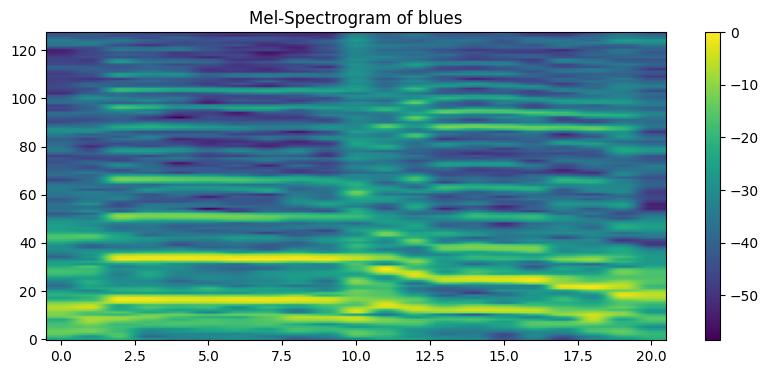

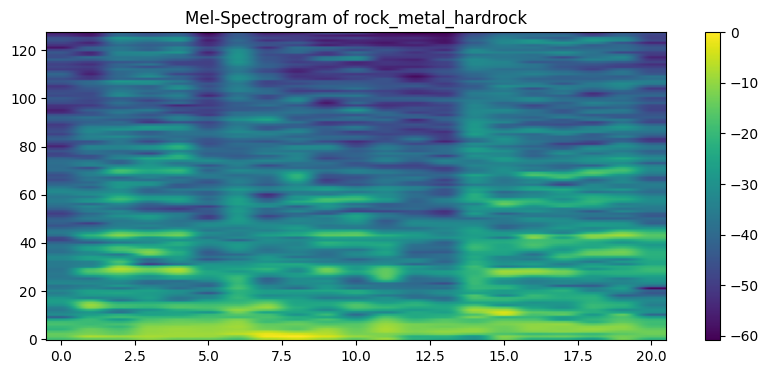

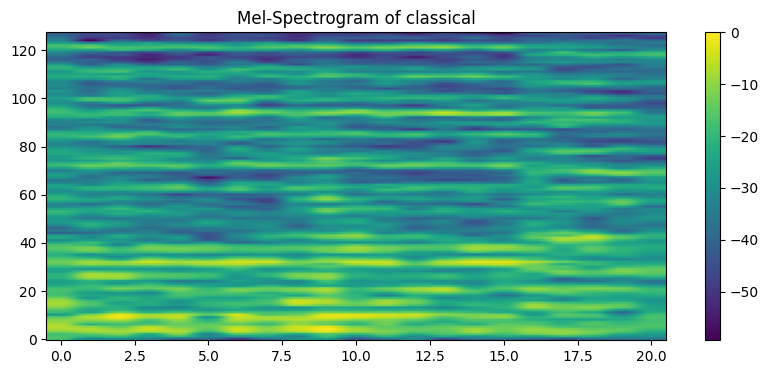

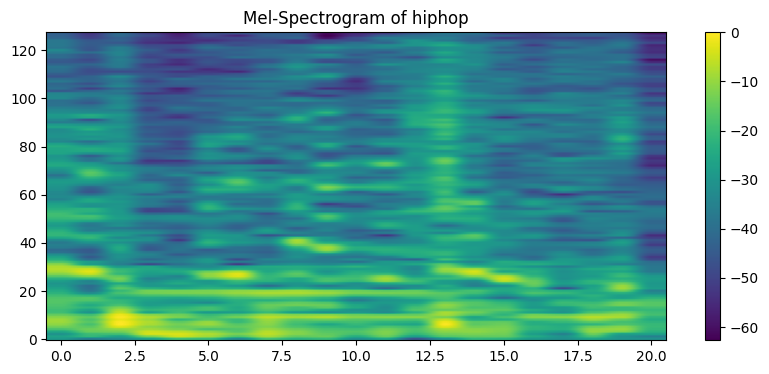

In [ ]:
def plot_melgram(melgram, label):
    plt.figure(figsize=(10, 4))
    plt.imshow(melgram.numpy().T, aspect='auto', origin='lower')
    plt.title(f'Mel-Spectrogram of {label}')
    plt.colorbar()
    plt.show()

labels_map_reverse = {v: k for k, v in labels_map.items()}

num_classes = len(labels_map)
for i in range(num_classes):
    class_samples = [idx for idx, label in enumerate(train_melgrams_labels_code) if label == i]
    random_idx = np.random.choice(class_samples)
    melgram, label_code = train_melgrams_dataset[random_idx]
    label_str = labels_map_reverse[label_code.item()]
    plot_melgram(melgram, label_str)

## Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [ ]:
class MusicGenreCNN(nn.Module):
    def __init__(self, input_shape, num_classes=4):
        super(MusicGenreCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        )

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            flattened_dim = self.flatten(self.conv_layers(dummy_input)).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_dim, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

## Βήμα 3: Εκπαίδευση δικτύου

In [ ]:
def train_cnn(train_dataloader, model, criterion, optimizer, device, epochs):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    return model

Παρατηρούμε ότι το δίκτυο μπορεί να εκπαιδευτεί με επιτυχία και σε CPU και σε GPU (χρησιμοποιώντας τον κώδικα που υλοποιήσαμε στο παραπάνω ερώτημα, Βήμα 6). Η εκπαίδευση του δικτύου σε GPU είναι γενικά γρηγορότερη, σε σχέση με τη CPU. Η επιτάχυνση εξαρτάται από διάφορους παράγοντες, όπως η πολυπλοκότητα του μοντέλου, το μέγεθος και το υλικό της GPU. \\
Yπάρχουν διαφορές στον χρόνο εκτέλεσης μεταξύ της εκπαίδευσης του CNN και του πλήρως συνδεδεμένου νευρωνικού δικτύου του ερωτήματος 1 λόγω των διαφορών στην αρχιτεκτονική. Τα συνεπτυγμένα επίπεδα είναι γενικά πιο εντατικά από υπολογιστική άποψη από τα πλήρως συνδεδεμένα επίπεδα, ειδικά για μεγάλους όγκους εισόδου. Επιπλέον, η εκπαίδευση των συνελικτικών στρωμάτων μπορεί να ωφεληθεί περισσότερο από την επιτάχυνση της GPU λόγω του παραλληλισμού που ενυπάρχει στις συνελικτικές λειτουργίες.  

## Βήμα 4: Pooling and padding

In [ ]:
class MusicGenreCNN(nn.Module):
    def __init__(self, input_shape, num_classes=4):
        super(MusicGenreCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            flattened_dim = self.flatten(self.conv_layers(dummy_input)).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_dim, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

input_shape = (1, 26, 128)
num_classes = 4

model = MusicGenreCNN(input_shape, num_classes)
print(model)


MusicGenreCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=4, bias=Tr

Το Padding εξασφαλίζει ότι οι χωρικές διαστάσεις των χαρακτηριστικών παραμένουν ίδιες μετά από κάθε συνέλιξη. Αυτό συμβάλλει στην αποφυγή απώλειας πληροφοριών. Το Max pooling μειώνει τα δείγματα των χαρτών χαρακτηριστικών λαμβάνοντας τη μέγιστη τιμή εντός κάθε παραθύρου. Βοηθά στη μείωση των χωρικών διαστάσεων των χαρτών χαρακτηριστικών, διατηρώντας παράλληλα τις πιο σχετικές πληροφορίες. \\
Ο χρόνος εκπαίδευσης μπορεί να αυξηθεί ελαφρώς λόγω των πρόσθετων υπολογισμών που απαιτούνται για τις λειτουργίες padding και max pooling. Ωστόσο, ο συνολικός αντίκτυπος στον χρόνο εκπαίδευσης μπορεί να ποικίλλει ανάλογα με παράγοντες όπως η αρχιτεκτονική του μοντέλου, το μέγεθος των δεδομένων και το υλικό που χρησιμοποιείται για την εκπαίδευση.

## Βήμα 5: Activation functions

In [ ]:
import torch
import torch.nn as nn

class MusicGenreCNN(nn.Module):
    def __init__(self, input_shape, num_classes=4):
        super(MusicGenreCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            flattened_dim = self.flatten(self.conv_layers(dummy_input)).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

input_shape = (1, 26, 128)
num_classes = 4

model = MusicGenreCNN(input_shape, num_classes)

print(model)

MusicGenreCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in

Η εισαγωγή ReLU σε κάθε επίπεδο επιτρέπει στο δίκτυο να μαθαίνει πιο σύνθετες αναπαραστάσεις των δεδομένων εισάγοντας μη γραμμικότητες. Η ReLU βοηθά στην αντιμετώπιση του προβλήματος της εξαφανιζόμενης κλίσης και επιταχύνει τη σύγκλιση της διαδικασίας εκπαίδευσης. Επιτρέποντας στο μοντέλο να μάθει μη γραμμικές σχέσεις μεταξύ των χαρακτηριστικών εισόδου, οι συναρτήσεις ενεργοποίησης ReLU μπορούν να οδηγήσουν σε βελτιωμένη απόδοση όσον αφορά την ακρίβεια και τη γενίκευση.

## **Ερώτημα 3: Improving Performance**

## Βήμα 1: Reproducibility

Για να βελτιώσουμε την απόδοση του δικτύου θα δοκιμάσουμε διάφορες τεχνικές. Θα ορίσουμε τυχαίες τιμές για το PyTorch, το NumPy και την τυχαία ενότητα της Python. Θα εκπαιδεύσουμε το μοντέλο υπό τις ίδιες ακριβώς συνθήκες δύο φορές.
  

In [ ]:
import time
import torch
import os, random
from google.colab import drive
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
%pip install torchmetrics
from torchmetrics import ConfusionMatrix, MetricCollection
from sklearn.metrics import f1_score
torch.use_deterministic_algorithms(True)


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

class MelgramDataset(Dataset):
    def __init__(self, data_path, label_path, labels_map, transform=None):
        self.data = np.load(data_path)
        self.labels = np.load(label_path)
        self.labels_map = labels_map
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.labels_map[label]

labels_map = {
    "classical": 0,
    "blues": 1,
    "rock_metal_hardrock": 2,
    "hiphop": 3,
}

train_data_path = '/content/drive/MyDrive/ML3/music_genre_data_di/train/melgrams/X.npy'
train_label_path = '/content/drive/MyDrive/ML3/music_genre_data_di/train/melgrams/labels.npy'

val_data_path = '/content/drive/MyDrive/ML3/music_genre_data_di/val/melgrams/X.npy'
val_label_path = '/content/drive/MyDrive/ML3/music_genre_data_di/val/melgrams/labels.npy'

test_data_path = '/content/drive/MyDrive/ML3/music_genre_data_di/test/melgrams/X.npy'
test_label_path = '/content/drive/MyDrive/ML3/music_genre_data_di/test/melgrams/labels.npy'

train_dataset = MelgramDataset(train_data_path, train_label_path, labels_map, transform=ToTensor())
val_dataset = MelgramDataset(val_data_path, val_label_path, labels_map, transform=ToTensor())
test_dataset = MelgramDataset(test_data_path, test_label_path, labels_map, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.CELU(),
            nn.Linear(1024, 256),
            nn.CELU(),
            nn.Linear(256, 32),
            nn.CELU(),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits


model = LeNet().to(device)

def train_with_validation(model, train_loader, val_loader, optimizer, criterion, num_epochs=30):
    best_model = None
    best_val_f1 = -1
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_inputs, val_labels = next(iter(val_loader))
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels).item()
            val_preds = val_outputs.argmax(dim=1)
            val_f1 = f1_score(val_preds.cpu().numpy(), val_labels.cpu().numpy(), average='macro')

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {loss.item():.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val F1: {val_f1:.4f}")

    return best_model

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

best_model_state = train_with_validation(model, train_loader, val_loader, optimizer, criterion)

model.load_state_dict(best_model_state)

def test(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        test_inputs, test_labels = next(iter(test_loader))
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels).item()
        test_preds = test_outputs.argmax(dim=1)
        test_f1 = f1_score(test_preds.cpu().numpy(), test_labels.cpu().numpy(), average='macro')
        confusion_matrix = ConfusionMatrix(num_classes=4, task='multiclass')
        confusion_matrix.update(test_preds, test_labels)

    print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix.compute().cpu()}")

test(model, test_loader, criterion)

Epoch [1/30], Train Loss: 0.7976, Val Loss: 0.8665, Val F1: 0.6396
Epoch [2/30], Train Loss: 0.8779, Val Loss: 0.7542, Val F1: 0.7086
Epoch [3/30], Train Loss: 0.5747, Val Loss: 0.6897, Val F1: 0.7198
Epoch [4/30], Train Loss: 0.4495, Val Loss: 0.6923, Val F1: 0.6990
Epoch [5/30], Train Loss: 0.4402, Val Loss: 0.6935, Val F1: 0.6992
Epoch [6/30], Train Loss: 0.6932, Val Loss: 0.6709, Val F1: 0.7432
Epoch [7/30], Train Loss: 0.3952, Val Loss: 0.5855, Val F1: 0.7792
Epoch [8/30], Train Loss: 0.4895, Val Loss: 0.5911, Val F1: 0.7818
Epoch [9/30], Train Loss: 0.5617, Val Loss: 0.6190, Val F1: 0.7555
Epoch [10/30], Train Loss: 0.7392, Val Loss: 0.5868, Val F1: 0.7884
Epoch [11/30], Train Loss: 0.1576, Val Loss: 0.5893, Val F1: 0.7780
Epoch [12/30], Train Loss: 0.3121, Val Loss: 0.5793, Val F1: 0.7938
Epoch [13/30], Train Loss: 0.4002, Val Loss: 0.5980, Val F1: 0.7860
Epoch [14/30], Train Loss: 0.2721, Val Loss: 0.6752, Val F1: 0.7601
Epoch [15/30], Train Loss: 0.2193, Val Loss: 0.7857, Val 

## Βήμα 2 : Αλγόριθμοι βελτιστοποίησης

Σε αυτό το ερώτημα θα τεστάρουμε ενδεικτικά 5 αλγόριθμους με 10 εποχές τον κάθε ένα, καθώς όσο αυξάνουμε είτε τους αλγόριθμους είτε τις εποχές, ο χρόνος εκτέλεσης του κώδικα αυξάνεται δραματικά.

In [ ]:
from tqdm import tqdm
import torch.optim as optim

class LeNetwithfun(nn.Module):
    def __init__(self, fun, num_classes=10) -> None:
        super(LeNetwithfun, self).__init__()
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            fun(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            fun(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            fun(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            fun(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128, 128),
            fun(),
            nn.Linear(128, 32),
            fun(),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

def training_with_validation(model, train_loader, val_loader, optimizer, criterion, num_epochs=30):
    best_model = None
    best_val_f1 = -1
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)

        model.eval()
        val_preds = []
        val_labels_list = []
        val_loss = 0.0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                val_labels_list.extend(val_labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_f1 = f1_score(val_labels_list, val_preds, average='macro')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val F1: {val_f1:.4f}")

    return best_model

def testing(model, test_loader, criterion):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    test_preds = []
    test_labels_list = []
    test_loss = 0.0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            test_preds.extend(test_outputs.argmax(dim=1).cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_f1 = f1_score(test_labels_list, test_preds, average='macro')

    print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

    return test_loss, test_f1, test_preds, test_labels_list

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

learning_rate = 0.002
num_epochs = 10
num_classes = 10

activation_functions = [
    nn.ELU, nn.Hardshrink, nn.Hardsigmoid, nn.Hardtanh, nn.Hardswish
]

results = {}

for activation in activation_functions:
    print(f"Testing with activation function: {activation.__name__}")
    model = LeNetwithfun(activation, num_classes=num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    best_model = training_with_validation(model, train_loader, test_loader, optimizer, nn.CrossEntropyLoss(), num_epochs=num_epochs)
    test_loss, test_f1, _, _ = testing(model, test_loader, nn.CrossEntropyLoss())
    results[activation.__name__] = {'test_loss': test_loss, 'test_f1': test_f1}

for activation, result in results.items():
    print(f"Activation: {activation}, Test Loss: {result['test_loss']:.4f}, Test F1: {result['test_f1']:.4f}")


Testing with activation function: ELU


Epoch 1/10: 100%|██████████| 938/938 [02:25<00:00,  6.43it/s]


Epoch [1/10], Train Loss: 2.3008, Val Loss: 2.2954, Val F1: 0.0183


Epoch 2/10: 100%|██████████| 938/938 [01:55<00:00,  8.11it/s]


Epoch [2/10], Train Loss: 2.2908, Val Loss: 2.2840, Val F1: 0.0985


Epoch 3/10: 100%|██████████| 938/938 [01:54<00:00,  8.21it/s]


Epoch [3/10], Train Loss: 2.2739, Val Loss: 2.2573, Val F1: 0.2406


Epoch 4/10: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


Epoch [4/10], Train Loss: 2.2115, Val Loss: 2.1167, Val F1: 0.2233


Epoch 5/10: 100%|██████████| 938/938 [02:18<00:00,  6.78it/s]


Epoch [5/10], Train Loss: 1.8233, Val Loss: 1.3623, Val F1: 0.5233


Epoch 6/10: 100%|██████████| 938/938 [01:51<00:00,  8.42it/s]


Epoch [6/10], Train Loss: 0.9359, Val Loss: 0.6405, Val F1: 0.7999


Epoch 7/10: 100%|██████████| 938/938 [01:51<00:00,  8.44it/s]


Epoch [7/10], Train Loss: 0.5209, Val Loss: 0.3906, Val F1: 0.8805


Epoch 8/10: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Epoch [8/10], Train Loss: 0.3223, Val Loss: 0.2520, Val F1: 0.9226


Epoch 9/10: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]


Epoch [9/10], Train Loss: 0.2306, Val Loss: 0.1927, Val F1: 0.9405


Epoch 10/10: 100%|██████████| 938/938 [01:57<00:00,  7.98it/s]


Epoch [10/10], Train Loss: 0.1873, Val Loss: 0.1629, Val F1: 0.9500
Test Loss: 0.1629, Test F1: 0.9500
Testing with activation function: Hardshrink


Epoch 1/10: 100%|██████████| 938/938 [01:45<00:00,  8.92it/s]


Epoch [1/10], Train Loss: 2.3060, Val Loss: 2.3042, Val F1: 0.0179


Epoch 2/10: 100%|██████████| 938/938 [01:44<00:00,  8.96it/s]


Epoch [2/10], Train Loss: 2.3045, Val Loss: 2.3031, Val F1: 0.0204


Epoch 3/10: 100%|██████████| 938/938 [01:43<00:00,  9.04it/s]


Epoch [3/10], Train Loss: 2.3034, Val Loss: 2.3024, Val F1: 0.0204


Epoch 4/10: 100%|██████████| 938/938 [01:41<00:00,  9.21it/s]


Epoch [4/10], Train Loss: 2.3027, Val Loss: 2.3019, Val F1: 0.0204


Epoch 5/10: 100%|██████████| 938/938 [01:45<00:00,  8.90it/s]


Epoch [5/10], Train Loss: 2.3022, Val Loss: 2.3016, Val F1: 0.0204


Epoch 6/10: 100%|██████████| 938/938 [01:46<00:00,  8.84it/s]


Epoch [6/10], Train Loss: 2.3019, Val Loss: 2.3013, Val F1: 0.0204


Epoch 7/10: 100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


Epoch [7/10], Train Loss: 2.3017, Val Loss: 2.3012, Val F1: 0.0204


Epoch 8/10: 100%|██████████| 938/938 [01:46<00:00,  8.85it/s]


Epoch [8/10], Train Loss: 2.3015, Val Loss: 2.3011, Val F1: 0.0204


Epoch 9/10: 100%|██████████| 938/938 [01:43<00:00,  9.10it/s]


Epoch [9/10], Train Loss: 2.3014, Val Loss: 2.3011, Val F1: 0.0204


Epoch 10/10: 100%|██████████| 938/938 [01:45<00:00,  8.89it/s]


Epoch [10/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204
Test Loss: 2.3010, Test F1: 0.0204
Testing with activation function: Hardsigmoid


Epoch 1/10: 100%|██████████| 938/938 [01:48<00:00,  8.61it/s]


Epoch [1/10], Train Loss: 2.3165, Val Loss: 2.3025, Val F1: 0.0183


Epoch 2/10: 100%|██████████| 938/938 [01:48<00:00,  8.67it/s]


Epoch [2/10], Train Loss: 2.3017, Val Loss: 2.3011, Val F1: 0.0204


Epoch 3/10: 100%|██████████| 938/938 [01:45<00:00,  8.90it/s]


Epoch [3/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204


Epoch 4/10: 100%|██████████| 938/938 [01:47<00:00,  8.72it/s]


Epoch [4/10], Train Loss: 2.3013, Val Loss: 2.3011, Val F1: 0.0204


Epoch 5/10: 100%|██████████| 938/938 [01:46<00:00,  8.80it/s]


Epoch [5/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204


Epoch 6/10: 100%|██████████| 938/938 [01:47<00:00,  8.72it/s]


Epoch [6/10], Train Loss: 2.3012, Val Loss: 2.3011, Val F1: 0.0204


Epoch 7/10: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


Epoch [7/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204


Epoch 8/10: 100%|██████████| 938/938 [01:53<00:00,  8.29it/s]


Epoch [8/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204


Epoch 9/10: 100%|██████████| 938/938 [01:54<00:00,  8.18it/s]


Epoch [9/10], Train Loss: 2.3013, Val Loss: 2.3011, Val F1: 0.0204


Epoch 10/10: 100%|██████████| 938/938 [01:59<00:00,  7.86it/s]


Epoch [10/10], Train Loss: 2.3013, Val Loss: 2.3010, Val F1: 0.0204
Test Loss: 2.3010, Test F1: 0.0204
Testing with activation function: Hardtanh


Epoch 1/10: 100%|██████████| 938/938 [01:57<00:00,  8.01it/s]


Epoch [1/10], Train Loss: 2.3051, Val Loss: 2.2979, Val F1: 0.0350


Epoch 2/10: 100%|██████████| 938/938 [01:54<00:00,  8.22it/s]


Epoch [2/10], Train Loss: 2.2875, Val Loss: 2.2723, Val F1: 0.1643


Epoch 3/10: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]


Epoch [3/10], Train Loss: 2.2254, Val Loss: 2.1293, Val F1: 0.1743


Epoch 4/10: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Epoch [4/10], Train Loss: 1.9357, Val Loss: 1.7032, Val F1: 0.4467


Epoch 5/10: 100%|██████████| 938/938 [01:48<00:00,  8.64it/s]


Epoch [5/10], Train Loss: 1.4521, Val Loss: 1.2344, Val F1: 0.5935


Epoch 6/10: 100%|██████████| 938/938 [01:48<00:00,  8.62it/s]


Epoch [6/10], Train Loss: 1.0905, Val Loss: 0.9448, Val F1: 0.7149


Epoch 7/10: 100%|██████████| 938/938 [01:48<00:00,  8.61it/s]


Epoch [7/10], Train Loss: 0.8233, Val Loss: 0.6969, Val F1: 0.7837


Epoch 8/10: 100%|██████████| 938/938 [01:49<00:00,  8.55it/s]


Epoch [8/10], Train Loss: 0.6309, Val Loss: 0.5527, Val F1: 0.8392


Epoch 9/10: 100%|██████████| 938/938 [01:50<00:00,  8.48it/s]


Epoch [9/10], Train Loss: 0.5044, Val Loss: 0.4324, Val F1: 0.8956


Epoch 10/10: 100%|██████████| 938/938 [01:49<00:00,  8.54it/s]


Epoch [10/10], Train Loss: 0.4023, Val Loss: 0.3446, Val F1: 0.9241
Test Loss: 0.3446, Test F1: 0.9241
Testing with activation function: Hardswish


Epoch 1/10: 100%|██████████| 938/938 [01:50<00:00,  8.49it/s]


Epoch [1/10], Train Loss: 2.3059, Val Loss: 2.3050, Val F1: 0.0204


Epoch 2/10: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]


Epoch [2/10], Train Loss: 2.3043, Val Loss: 2.3037, Val F1: 0.0204


Epoch 3/10: 100%|██████████| 938/938 [01:53<00:00,  8.29it/s]


Epoch [3/10], Train Loss: 2.3033, Val Loss: 2.3028, Val F1: 0.0204


Epoch 4/10: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


Epoch [4/10], Train Loss: 2.3026, Val Loss: 2.3022, Val F1: 0.0204


Epoch 5/10: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Epoch [5/10], Train Loss: 2.3021, Val Loss: 2.3018, Val F1: 0.0204


Epoch 6/10: 100%|██████████| 938/938 [01:55<00:00,  8.14it/s]


Epoch [6/10], Train Loss: 2.3018, Val Loss: 2.3016, Val F1: 0.0204


Epoch 7/10: 100%|██████████| 938/938 [01:51<00:00,  8.44it/s]


Epoch [7/10], Train Loss: 2.3016, Val Loss: 2.3014, Val F1: 0.0204


Epoch 8/10: 100%|██████████| 938/938 [01:54<00:00,  8.21it/s]


Epoch [8/10], Train Loss: 2.3014, Val Loss: 2.3013, Val F1: 0.0204


Epoch 9/10: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Epoch [9/10], Train Loss: 2.3013, Val Loss: 2.3012, Val F1: 0.0204


Epoch 10/10: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]


Epoch [10/10], Train Loss: 2.3013, Val Loss: 2.3011, Val F1: 0.0204
Test Loss: 2.3011, Test F1: 0.0204
Activation: ELU, Test Loss: 0.1629, Test F1: 0.9500
Activation: Hardshrink, Test Loss: 2.3010, Test F1: 0.0204
Activation: Hardsigmoid, Test Loss: 2.3010, Test F1: 0.0204
Activation: Hardtanh, Test Loss: 0.3446, Test F1: 0.9241
Activation: Hardswish, Test Loss: 2.3011, Test F1: 0.0204


## Βήμα 3 : Batch Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.targets[index]
        return sample, label

labels_map = {
    "blues": 0,
    "rock_metal_hardrock": 1,
    "classical": 2,
    "hiphop": 3
}

def mapping_function(labels_map, x):
    return labels_map[x]

class LeNet_with_batchnorm2d(nn.Module):
    def __init__(self):
        super(LeNet_with_batchnorm2d, self).__init__()
        self.convolution_layer = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128 * 1 * 8, 1024),
            nn.CELU(),
            nn.Linear(1024, 256),
            nn.CELU(),
            nn.Linear(256, 32),
            nn.CELU(),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

def training_with_scheduler(num_epochs, optimizer, train_loader, val_loader, criterion, model, scheduler):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    print(f"Best val Acc: {best_acc:4f}")
    model.load_state_dict(best_model_wts)
    return model

def testing(test_loader, criterion, model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    return test_loss, test_f1, test_acc.item()

num_samples = 1000
input_shape = (1, 26, 128)
num_classes = 4

data = torch.randn(num_samples, *input_shape)
labels = np.random.choice(list(labels_map.values()), num_samples)

train_dataset = CustomDataset(data[:800], labels[:800])
val_dataset = CustomDataset(data[800:900], labels[800:900])
test_dataset = CustomDataset(data[900:], labels[900:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
model = LeNet_with_batchnorm2d().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, verbose=True)

best_model = training_with_scheduler(num_epochs, optimizer, train_loader, val_loader, costfun, model, scheduler)
test_loss, test_f1, test_acc = testing(test_loader, costfun, best_model)

print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.6f}, Test F1 Score: {test_f1:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/30
Training Loss: 1.4199 Acc: 0.2462
Validation Loss: 1.3820 Acc: 0.3500
Epoch 2/30
Training Loss: 0.9064 Acc: 0.7625
Validation Loss: 1.6433 Acc: 0.3100
Epoch 3/30
Training Loss: 0.0504 Acc: 1.0000
Validation Loss: 1.8195 Acc: 0.2500
Epoch 4/30
Training Loss: 0.0092 Acc: 1.0000
Validation Loss: 1.9397 Acc: 0.3200
Epoch 5/30
Training Loss: 0.0050 Acc: 1.0000
Validation Loss: 2.0018 Acc: 0.3200
Epoch 6/30
Training Loss: 0.0033 Acc: 1.0000
Validation Loss: 2.0511 Acc: 0.3200
Epoch 7/30
Training Loss: 0.0024 Acc: 1.0000
Validation Loss: 2.0898 Acc: 0.3200
Epoch 8/30
Training Loss: 0.0019 Acc: 1.0000
Validation Loss: 2.1220 Acc: 0.3200
Epoch 9/30
Training Loss: 0.0015 Acc: 1.0000
Validation Loss: 2.1499 Acc: 0.3200
Epoch 10/30
Training Loss: 0.0013 Acc: 1.0000
Validation Loss: 2.1768 Acc: 0.3300
Epoch 11/30
Training Loss: 0.0012 Acc: 1.0000
Validation Loss: 2.1702 Acc: 0.3300
Epoch 12/30
Training Loss: 0.0011 Acc: 1.0000
Validation Loss: 2.1804 Acc: 0.3200
Epoch 13/30
Training Loss

## Βήμα 4 : Regularization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

class LeNet_with_batchnormd(nn.Module):
    def __init__(self, per):
        super(LeNet_with_batchnormd, self).__init__()
        self.convolution_layer = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.CELU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128 * 1 * 8, 1024),
            nn.Dropout(p=per),
            nn.CELU(),
            nn.Linear(1024, 256),
            nn.Dropout(p=per),
            nn.CELU(),
            nn.Linear(256, 32),
            nn.Dropout(p=per),
            nn.CELU(),
            nn.Linear(32, 4),
            nn.Dropout(p=per),
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.targets[index]
        return sample, label

def training_with_scheduler(num_epochs, optimizer, train_loader, val_loader, criterion, model, scheduler):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    print(f"Best val Acc: {best_acc:4f}")
    model.load_state_dict(best_model_wts)
    return model

def testing(test_loader, criterion, model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    return test_loss, test_f1, test_acc.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.002
num_epochs_list = [30, 60]

num_samples = 1000
input_shape = (1, 26, 128)
data = torch.randn(num_samples, *input_shape)
labels = np.random.randint(0, 4, num_samples)

train_dataset = CustomDataset(data[:800], labels[:800])
val_dataset = CustomDataset(data[800:900], labels[800:900])
test_dataset = CustomDataset(data[900:], labels[900:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for num_epochs in num_epochs_list:
    print(f"Epochs: {num_epochs}")
    for (per, wd) in [(0.1, 1e-8), (0.1, 1e-5), (0.1, 1e-3),
                      (0.2, 1e-8), (0.2, 1e-5), (0.2, 1e-3),
                      (0.3, 1e-8), (0.3, 1e-5), (0.3, 1e-3),
                      (0.4, 1e-8), (0.4, 1e-5), (0.4, 1e-3)]:

        model = LeNet_with_batchnormd(per).to(device)
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

        best_model = training_with_scheduler(num_epochs, optimizer, train_loader, val_loader, costfun, model, scheduler)

        test_loss, test_f1, test_acc = testing(test_loader, costfun, best_model)
        val_loss, val_f1, val_acc = testing(val_loader, costfun, best_model)

        print(f"For weight decay = {wd} and dropout = {per}:")
        print(f"  Test Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
        print(f"  Validation Accuracy: {val_acc:.4f}, Validation F1 Score: {val_f1:.4f}")
        print()


Epochs: 30
Epoch 1/30
Training Loss: 1.4110 Acc: 0.2600
Validation Loss: 1.4025 Acc: 0.2000
Epoch 2/30
Training Loss: 1.0220 Acc: 0.6613
Validation Loss: 1.5194 Acc: 0.2500
Epoch 3/30
Training Loss: 0.2256 Acc: 0.9375
Validation Loss: 1.7003 Acc: 0.2600
Epoch 4/30
Training Loss: 0.0741 Acc: 0.9675
Validation Loss: 1.8309 Acc: 0.2900
Epoch 5/30
Training Loss: 0.0420 Acc: 0.9850
Validation Loss: 1.9114 Acc: 0.2600
Epoch 6/30
Training Loss: 0.0356 Acc: 0.9850
Validation Loss: 2.0115 Acc: 0.2600
Epoch 7/30
Training Loss: 0.0322 Acc: 0.9900
Validation Loss: 2.0808 Acc: 0.2400
Epoch 8/30
Training Loss: 0.0288 Acc: 0.9800
Validation Loss: 2.1202 Acc: 0.2600
Epoch 9/30
Training Loss: 0.0325 Acc: 0.9762
Validation Loss: 2.2485 Acc: 0.2600
Epoch 10/30
Training Loss: 0.0286 Acc: 0.9825
Validation Loss: 2.2187 Acc: 0.2400
Epoch 11/30
Training Loss: 0.0272 Acc: 0.9862
Validation Loss: 2.2153 Acc: 0.2400
Epoch 12/30
Training Loss: 0.0288 Acc: 0.9825
Validation Loss: 2.2274 Acc: 0.2300
Epoch 13/30
Tr

Tο Dropout είναι μια τεχνική κανονικοποίησης που χρησιμοποιείται για την αποφυγή της υπερπροσαρμογής με τυχαία απομάκρυνση μονάδων (μαζί με τις συνδέσεις τους) κατά τη διάρκεια της εκπαίδευσης. Υψηλότερα ποσοστά εγκατάλειψης (π.χ. 0,3, 0,4) οδηγούν γενικά σε καλύτερες επιδόσεις γενίκευσης (υψηλότερη ακρίβεια επικύρωσης και βαθμολογία F1) σε σύγκριση με χαμηλότερα ποσοστά (π.χ. 0,1, 0,2). Αυτό είναι πιθανό επειδή τα υψηλότερα ποσοστά εγκατάλειψης βοηθούν στη μείωση της υπερπροσαρμογής αποτρέποντας αποτελεσματικά τις πολύπλοκες συν-προσαρμογές των νευρώνων.
Το Weight Decay Η μείωση των βαρών (επίσης γνωστή ως L2 regularization) τιμωρεί τα μεγάλα βάρη στο νευρωνικό δίκτυο κατά τη διάρκεια της εκπαίδευσης για να αποτρέψει την υπερβολική προσαρμογή.
Μικρότερες τιμές αποσύνθεσης βάρους (π.χ. 1e-8) αποδίδουν γενικά καλύτερα, καθώς παρέχουν αρκετή κανονικοποίηση για να αποτρέψουν την υπερπροσαρμογή χωρίς να τιμωρούν υπερβολικά τα βάρη του μοντέλου. Μεγαλύτερες τιμές αποσύνθεσης βάρους (π.χ. 1e-3) μπορεί να οδηγήσουν σε υποπροσαρμογή, εάν η κανονικοποίηση είναι πολύ ισχυρή.

## **Ερώτημα 4: Testing**

## Βήμα 1 : Inference

Όταν αξιολογούμε τον ταξινομητή χρησιμοποιώντας το test set, προσπαθούμε να εκτιμήσουμε την ικανότητά του να γενικεύει σε δεδομένα που δεν έχει δει κατά τη διάρκεια της εκπαίδευσης. Για να ελέγξουμε πόσο ακριβής είναι αυτή η εκτίμηση, θα παράγουμε προβλέψεις για δεδομένα από τον πραγματικό κόσμο με βίντεο από το YouTube.

In [ ]:
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:  #don't need the labels
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())

    return predictions

#ex
device = 'cpu'
trained_cnn_model = model.to(device)
test_predictions = get_predictions(test_dataloader, trained_cnn_model, device)

print(test_predictions)

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [ ]:
import torch
from torch.utils.data import DataLoader

# Define the inference function
def inference(dataloader, model, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in dataloader:  # Don't need the labels
            inputs = inputs.to(device)
            inputs = torch.unsqueeze(inputs, 1)  # Add channel dimension if necessary

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())

    return predictions


## Βήμα 2 : Κατέβασμα μουσικής από το YouTube

In [ ]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,910 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,469 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/uni

In [ ]:
!pip install pytube pydub librosa numpy

from pytube import YouTube
from pydub import AudioSegment
import os
import librosa
import numpy as np

def download_youtube(youtube_url, output_path="output.wav"):
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(only_audio=True).first()
    audio_file = stream.download(filename='downloaded_audio')

    audio = AudioSegment.from_file(audio_file)
    audio.export(output_path, format="wav")

    os.remove(audio_file)

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Read audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    x, fs = librosa.load(filename, sr=None)
    return x, fs

def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None, fuse=False):
    """Returns a mel spectrogram."""
    if x is None:
        return None
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft, hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        out = spectrogram_dB.T
    return out

def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        progress += segment_length

    return segments

def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("youtube_melgrams.npy", melgrams)

urls = [
    "https://www.youtube.com/watch?v=FyzWDl0nz00",
    "https://www.youtube.com/watch?v=oygrmJFKYZY",
    "https://www.youtube.com/watch?v=l45f28PzfCI",
    "https://www.youtube.com/watch?v=9E6b3swbnWg"
]

for url in urls:
    youtube_to_melgram(url)
